In [89]:
import asyncio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import random
import os
import shutil

from inspect import iscoroutinefunction
from timeout_function_decorator import timeout
from statistics import mean, median_low

In [2]:
sns.set_theme('notebook')
sns.set_palette('colorblind')

In [3]:
def quick_sync_func(a, b):
    return a + b

def medium_sync_func(a, b):
    for _ in range(1000):
        a += b
    return a + b

def long_sync_func(a, b):
    for _ in range(10_000):
        a += b
    return a + b

def huge_sync_func(a, b):
    for _ in range(100_000):
        a += b
    return a + b

@timeout()
def quick_timeout_sync_func(a, b):
    return a + b

@timeout()
def medium_timeout_sync_func(a, b):
    for _ in range(1000):
        a += b
    return a + b

@timeout()
def long_timeout_sync_func(a, b):
    for _ in range(10_000):
        a += b
    return a + b

@timeout()
def huge_timeout_sync_func(a, b):
    for _ in range(100_000):
        a += b
    return a + b

In [4]:
async def quick_async_func(a, b):
    return a + b

async def medium_async_func(a, b):
    for _ in range(1000):
        a += b
    return a + b

async def long_async_func(a, b):
    for _ in range(10_000):
        a += b
    return a + b

async def huge_async_func(a, b):
    for _ in range(100_000):
        a += b
    return a + b

@timeout()
async def quick_timeout_async_func(a, b):
    return a + b

@timeout()
async def medium_timeout_async_func(a, b):
    for _ in range(1000):
        a += b
    return a + b

@timeout()
async def long_timeout_async_func(a, b):
    for _ in range(10_000):
        a += b
    return a + b

@timeout()
async def huge_timeout_async_func(a, b):
    for _ in range(100_000):
        a += b
    return a + b

In [5]:
def sync_experiment(func, n):
    a = 42
    b = 69
    start = time.time()
    for _ in range(n):
        func(a, b)
    end = time.time()
    return end - start

async def async_experiment(func, n):
    a = 42
    b = 69
    start = time.time()
    for _ in range(n):
        await func(a, b)
    end = time.time()
    return end - start

In [6]:
async def experiment_manager(func, experiment_length, number_of_experiments):
    avg = []
    if iscoroutinefunction(func):
        for _ in range(number_of_experiments):
            tmp = await async_experiment(func, experiment_length)
            avg.append(tmp)
    else:
        for _ in range(number_of_experiments):
            tmp = sync_experiment(func, experiment_length)
            avg.append(tmp)
    return mean(avg)

In [7]:
def progress_bar(current, target, width=100):
    percent = (current / target) * 100
    percent = min(percent, 100)
    left = round(width * percent // 100)
    right = width - left
    tags = "#" * left
    spaces = " " * right
    percents = f"{percent:3.0f}%"
    print("\r[", tags, spaces, "]", percents, sep="", end="")

In [8]:
MAX_TIME = 0.1
NUMBER_OF_EXPERIMENTS = 25

In [9]:
df = pd.DataFrame(columns=['function', 'number of calls', 'time to complete', 'timeout', 'async'])

In [10]:
async def create_data(func, wrapped, df):
    is_async = iscoroutinefunction(func)
    current_time = 0
    current_lenth = 1
    progress_bar(current_time, MAX_TIME)
    while current_time < MAX_TIME:
        current_time = await experiment_manager(func, current_lenth, NUMBER_OF_EXPERIMENTS)
        df.loc[len(df.index)] = [func.__name__, current_lenth, current_time, wrapped, is_async]
        progress_bar(current_time, MAX_TIME)
        current_lenth += 1

In [11]:
await create_data(quick_sync_func, False, df)

[####################################################################################################]100%  0%

In [12]:
await create_data(quick_timeout_sync_func, True, df)

[####################################################################################################]100%

In [13]:
await create_data(medium_sync_func, False, df)

[####################################################################################################]100%

In [14]:
await create_data(medium_timeout_sync_func, True, df)

[####################################################################################################]100%

In [15]:
await create_data(long_sync_func, False, df)

[####################################################################################################]100%

In [16]:
await create_data(long_timeout_sync_func, True, df)

[####################################################################################################]100%

In [17]:
await create_data(huge_sync_func, False, df)

[####################################################################################################]100%

In [18]:
await create_data(huge_timeout_sync_func, True, df)

[####################################################################################################]100%

In [19]:
await create_data(quick_async_func, False, df)

[####################################################################################################]100%

In [20]:
await create_data(quick_timeout_async_func, True, df)

[####################################################################################################]100%

In [21]:
await create_data(medium_async_func, False, df)

[####################################################################################################]100%

In [22]:
await create_data(medium_timeout_async_func, True, df)

[####################################################################################################]100%

In [23]:
await create_data(long_async_func, False, df)

[####################################################################################################]100%

In [24]:
await create_data(long_timeout_async_func, True, df)

[####################################################################################################]100%

In [25]:
await create_data(huge_async_func, False, df)

[####################################################################################################]100%

In [26]:
await create_data(huge_timeout_async_func, True, df)

[####################################################################################################]100%

In [92]:
if os.path.isdir("../performance"):
    shutil.rmtree("../performance")
os.makedirs("../performance")

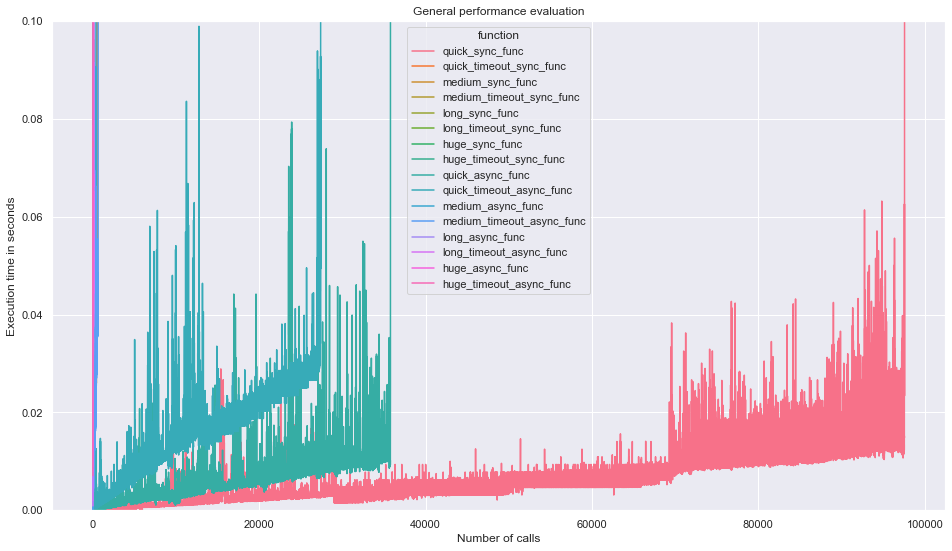

In [94]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df, x='number of calls', y='time to complete', hue='function')
plt.title('General performance evaluation')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig("../performance/general.png", backend='agg', dpi=300)
plt.show()

In [33]:
df_sync = df.query('`async` == False')
df_async = df.query('`async` == True')

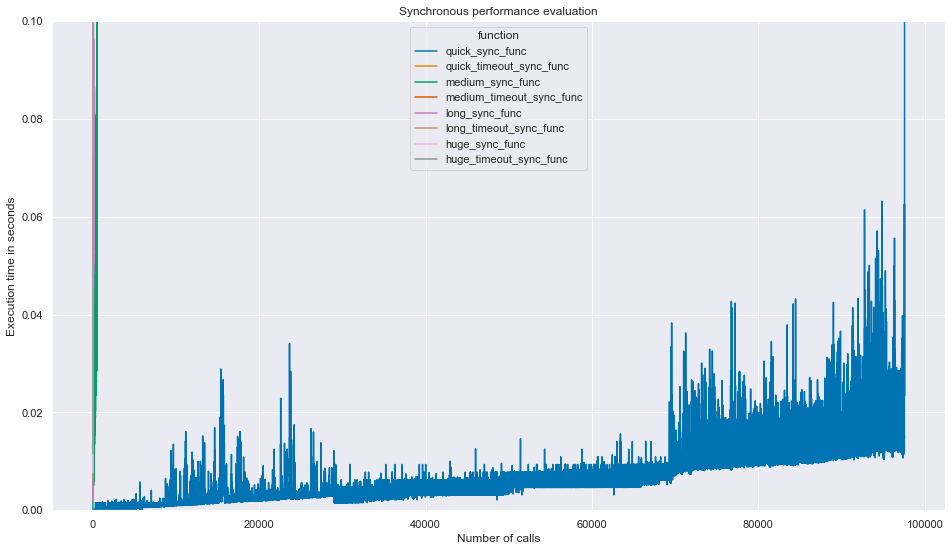

In [95]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig("../performance/sync.png", backend='agg', dpi=200)
plt.show()

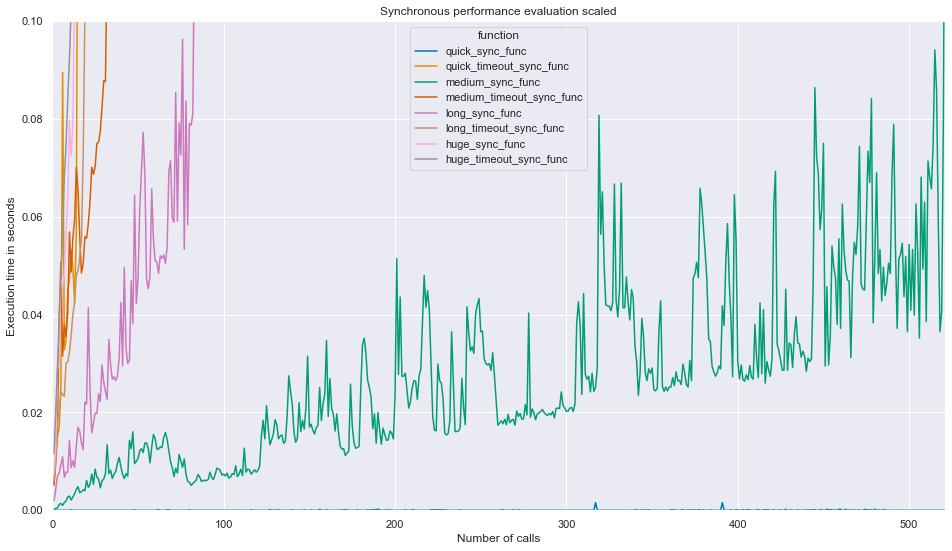

In [70]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation scaled')
plt.ylim(0, MAX_TIME)
plt.xlim(0, df_sync.query("not function.str.contains('quick')")['number of calls'].max())
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.show()

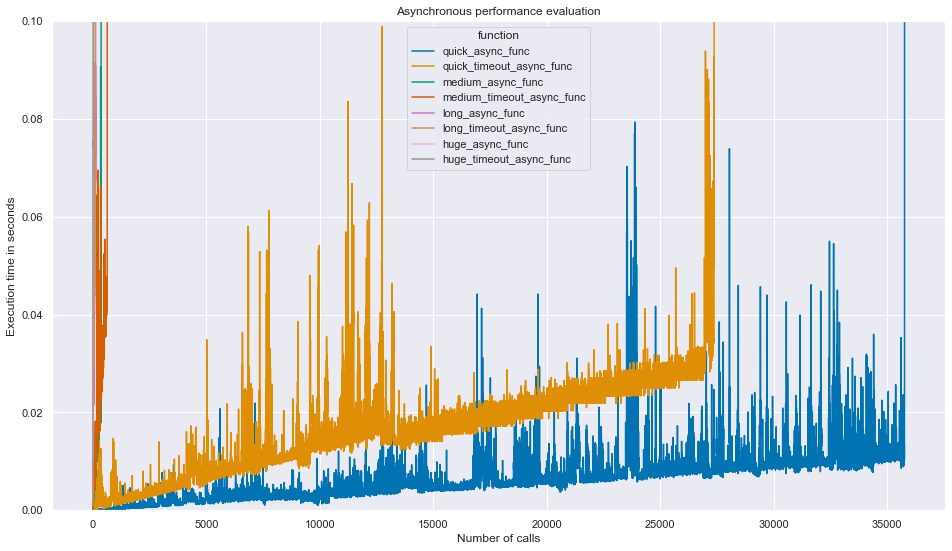

In [96]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/async.png', backend='agg', dpi=200)
plt.show()

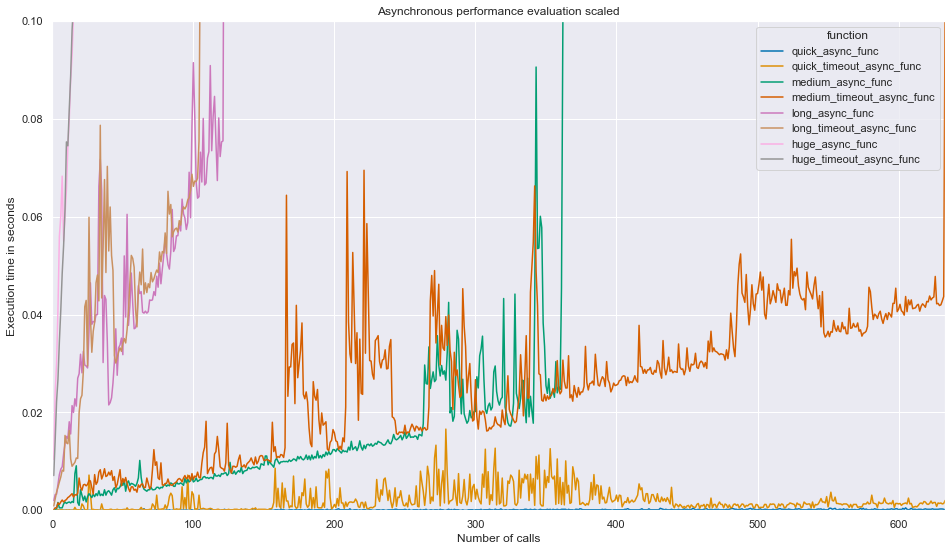

In [71]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation scaled')
plt.ylim(0, MAX_TIME)
plt.xlim(0, df_async.query("not function.str.contains('quick')")['number of calls'].max())
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.show()

In [53]:
df_quick_async = df_async.query('function.str.contains("quick")')
df_quick_sync = df_sync.query('function.str.contains("quick")')

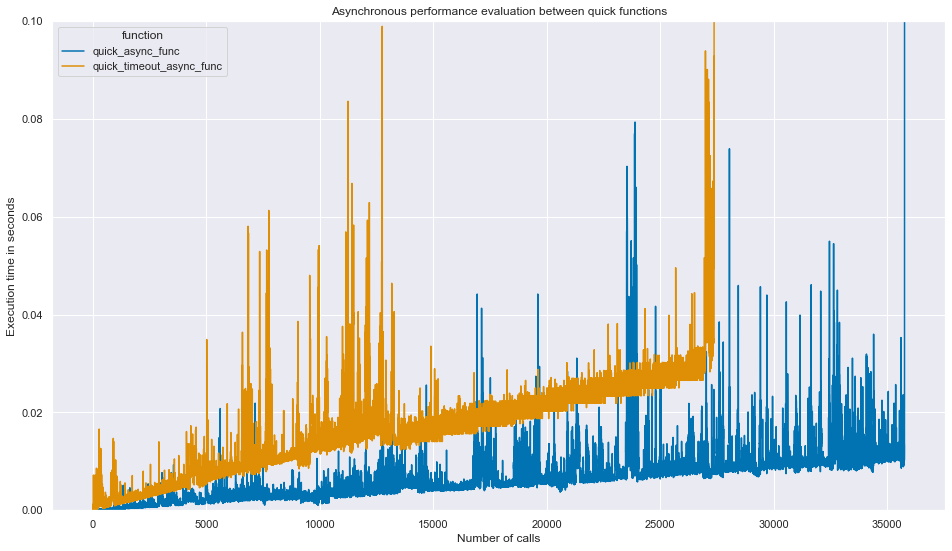

In [97]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_quick_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between quick functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig("../performance/async_quick.png", backend='agg')
plt.show()

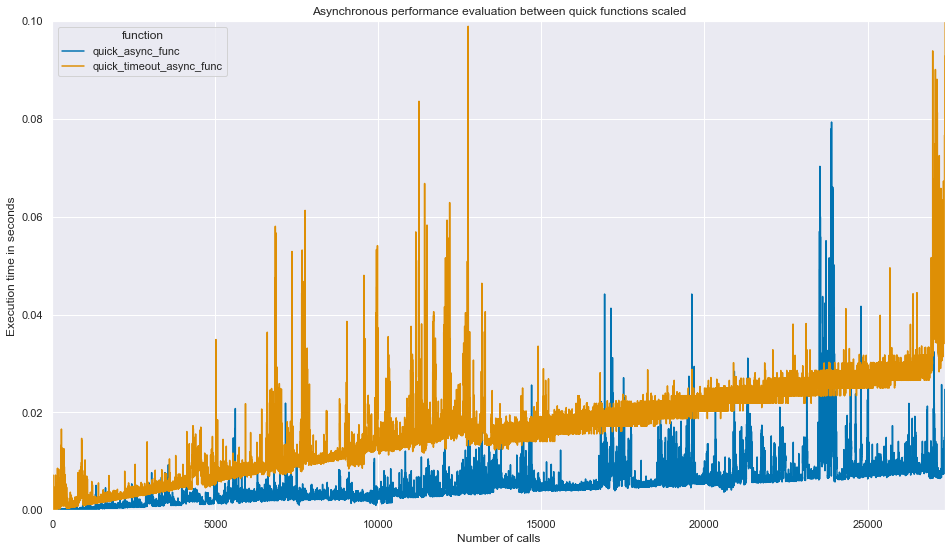

In [77]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_quick_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between quick functions scaled')
plt.ylim(0, MAX_TIME)
plt.xlim(0, df_quick_async.query("timeout == True")['number of calls'].max())
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.show()

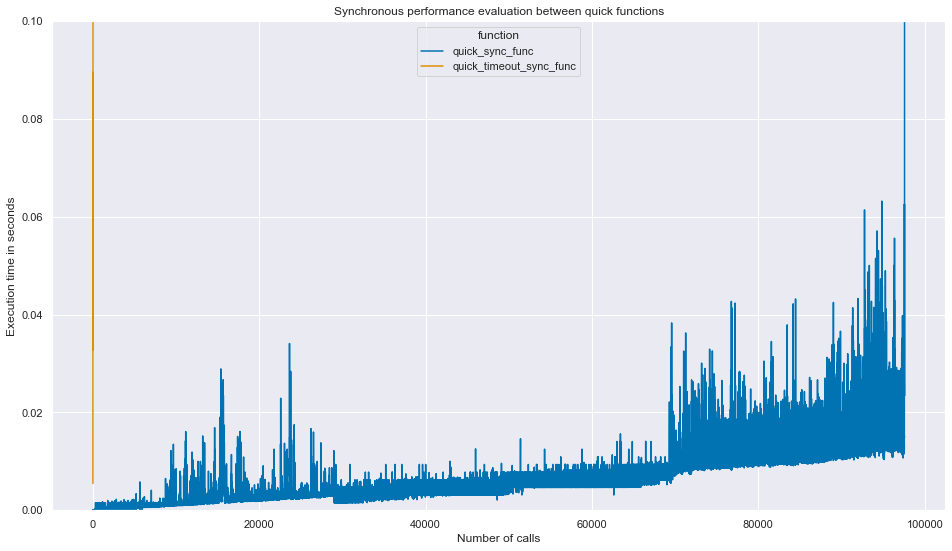

In [98]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_quick_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between quick functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/sync_quick.png', backend='agg')
plt.show()

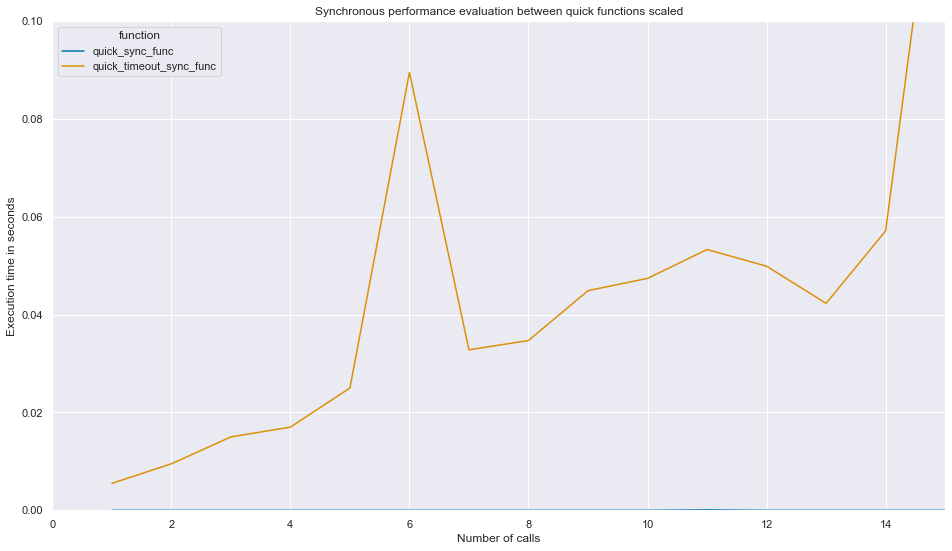

In [78]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_quick_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between quick functions scaled')
plt.ylim(0, MAX_TIME)
plt.xlim(0, df_quick_sync.query("timeout == True")['number of calls'].max())
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.show()

In [86]:
df_medium_sync = df_sync.query("function.str.contains('medium')")
df_medium_async = df_async.query("function.str.contains('medium')")

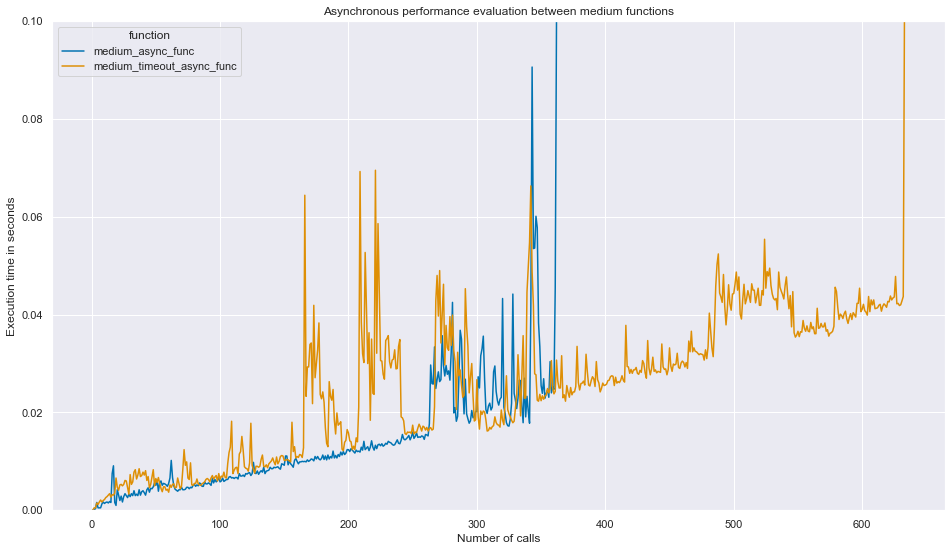

In [99]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_medium_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between medium functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/async_medium.png', backend='agg')
plt.show()

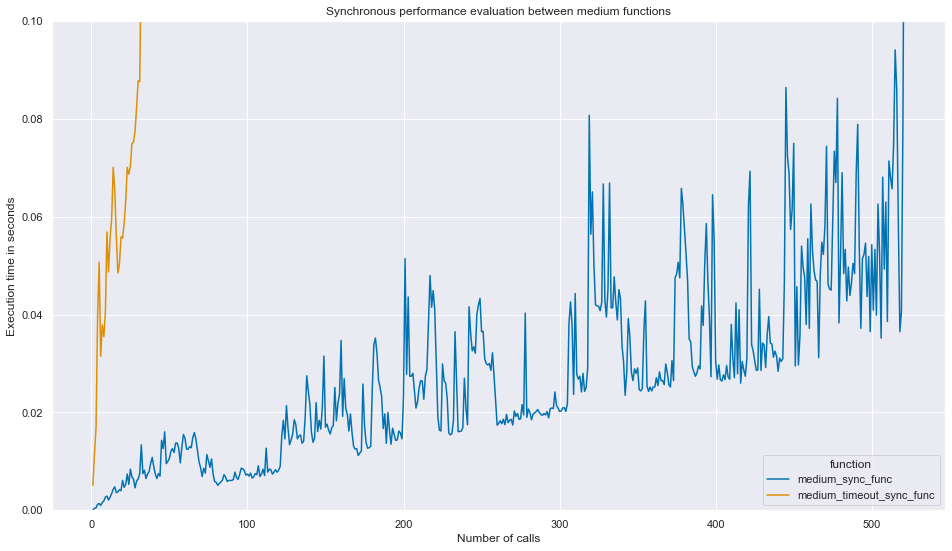

In [100]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_medium_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between medium functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/sync_medium.png', backend='agg')
plt.show()

In [80]:
df_long_sync = df_sync.query("function.str.contains('long')")
df_long_async = df_async.query("function.str.contains('long')")

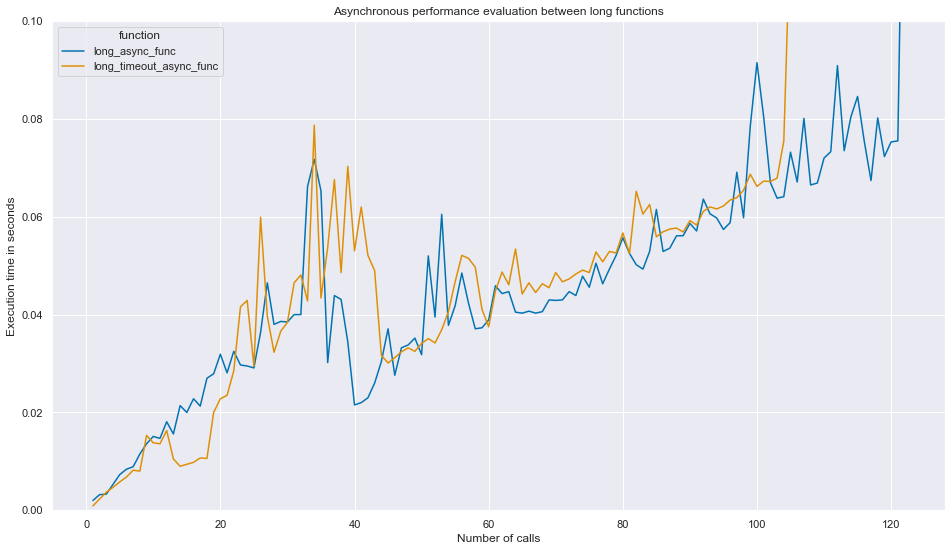

In [101]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_long_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between long functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/async_long.png', backend='agg')
plt.show()

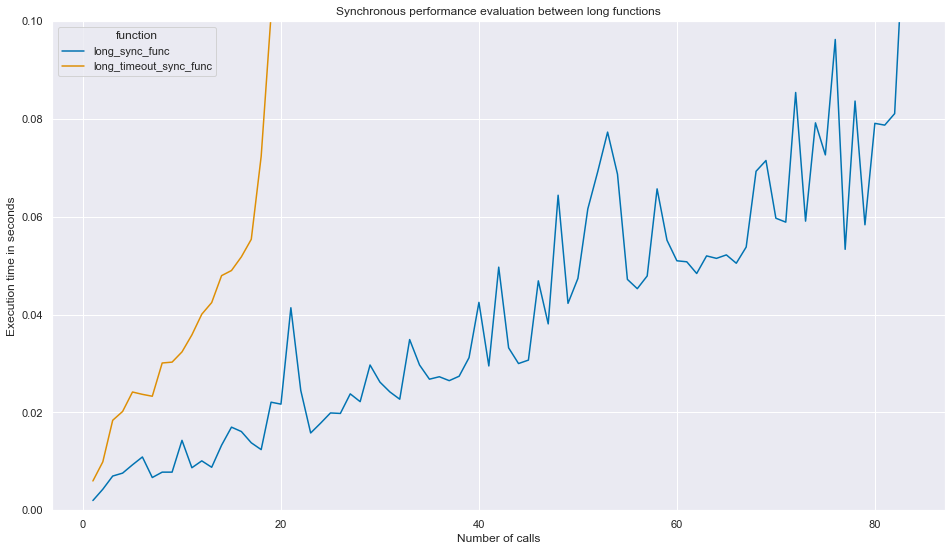

In [102]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_long_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between long functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/sync_long.png', backend='agg')
plt.show()

In [83]:
df_huge_sync = df_sync.query("function.str.contains('huge')")
df_huge_async = df_async.query("function.str.contains('huge')")

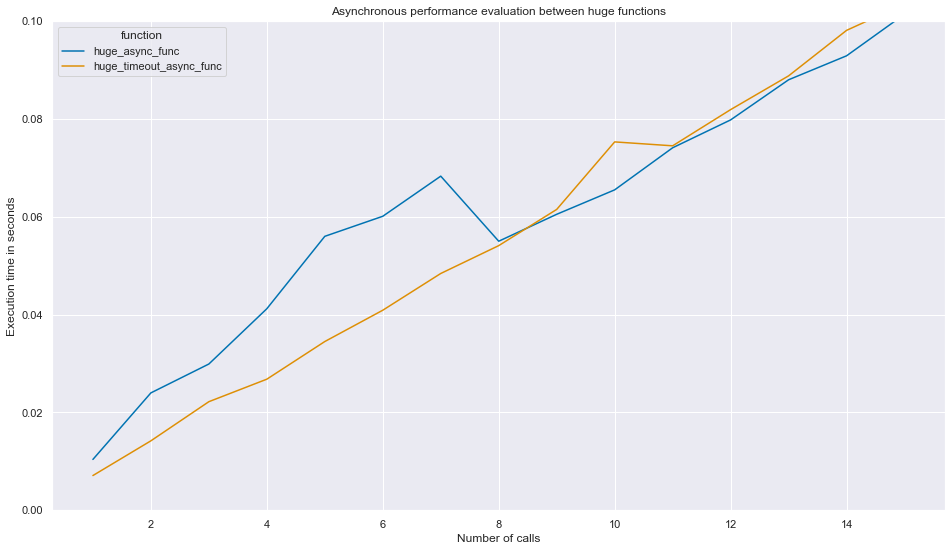

In [103]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_huge_async, x='number of calls', y='time to complete', hue='function')
plt.title('Asynchronous performance evaluation between huge functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/async_huge.png', backend='agg')
plt.show()

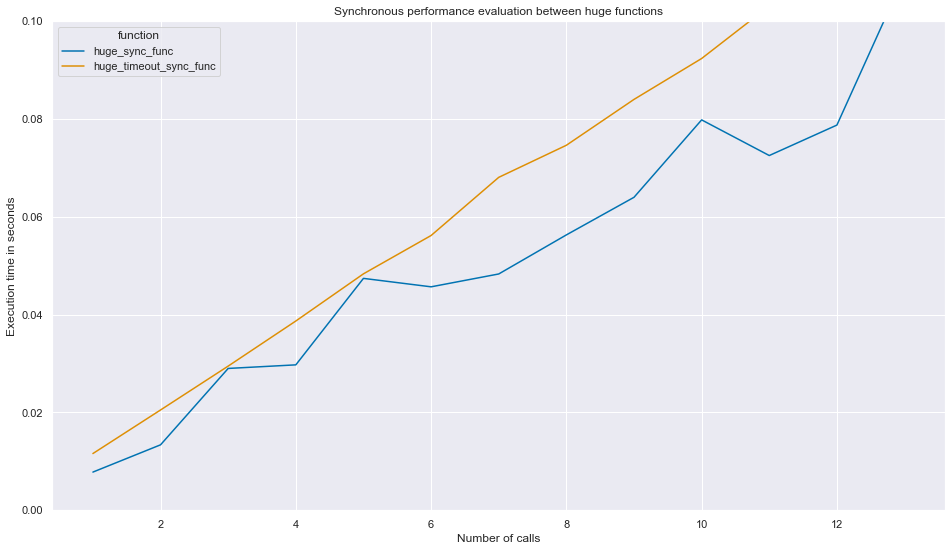

In [104]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df_huge_sync, x='number of calls', y='time to complete', hue='function')
plt.title('Synchronous performance evaluation between huge functions')
plt.ylim(0, MAX_TIME)
plt.ylabel('Execution time in seconds')
plt.xlabel('Number of calls')
plt.savefig('../performance/sync_huge.png', backend='agg')
plt.show()